In [1]:
import numpy as np
from mnist import MNIST
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import svm
from sklearn import tree

# I first used torchvision to download and extract the .gz compressed
# files, then used MNIST to read them as arrays. You can download and extract them however you like
# import torch
# import torchvision
# from torchvision import transforms, datasets

In [2]:
mndata = MNIST('MNIST\\raw')

train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

In [3]:
train_images, train_labels = np.transpose(np.array(train_images)), np.array(train_labels)
test_images, test_labels = np.transpose(np.array(test_images)), np.array(test_labels)

In [4]:
avg_im = np.mean(train_images, axis=1, keepdims=True)
Xc = train_images - avg_im

In [5]:
U, S, Vh = np.linalg.svd(Xc, full_matrices=False)  # economy otherwise requires 26 GB of ram

In [6]:
cumul_var = np.zeros(S.shape)
cumul_var[0] = S[0]**2
for i in range(1, S.shape[0]):
    cumul_var[i] = cumul_var[i-1] + S[i]**2

rank = 0
thresh = 0.9 * cumul_var[-1]
while cumul_var[rank] < thresh:
    rank += 1
print(rank)

86


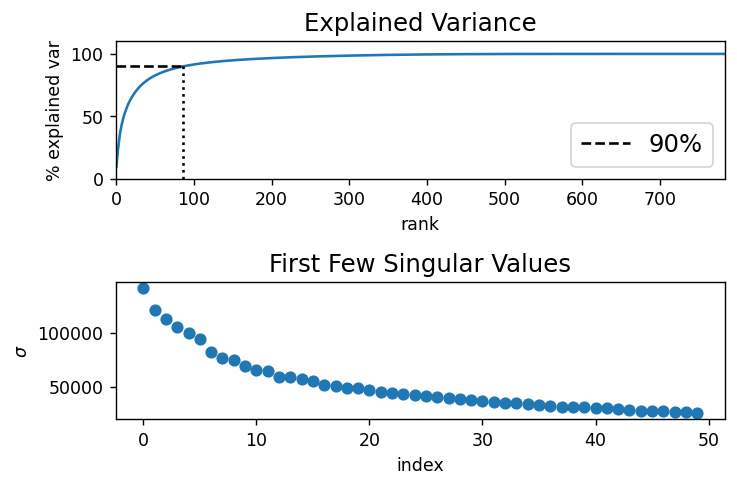

In [17]:
%matplotlib inline
plt.figure(dpi=125)
plt.subplot(211)
plt.plot(100 * cumul_var / cumul_var[-1])
plt.plot([rank, rank], [0, 90], ":k")
plt.plot([0, rank], [90, 90], "--k", label="90%")
plt.xlabel("rank")
plt.ylabel("% explained var")
plt.xlim([-1,784])
plt.ylim([0, 110])
plt.title("Explained Variance", fontsize=14)
plt.legend(fontsize=14)
plt.subplot(212)
plt.scatter(np.arange(50), S[:50])
plt.title("First Few Singular Values", fontsize=14)
plt.xlabel("index")
plt.ylabel("$\sigma$")
plt.tight_layout()
plt.show()

In [8]:
U.shape, S.shape, Vh.shape

((784, 784), (784,), (784, 60000))

$\Sigma$ is a diagonal matrix of singular values, whose entries indicate the relative importance of each of the basis vectors in $U$. The columns of $U$ are an orthogonal basis for all the 60,000 images in the dataset. The first column of $U$ is the most defining image of the dataset, as it is multiplied by the largest singular value. $V^T$ represents each of the 60,000 images in the orthogonal basis formed by the columns of $U \Sigma$. 

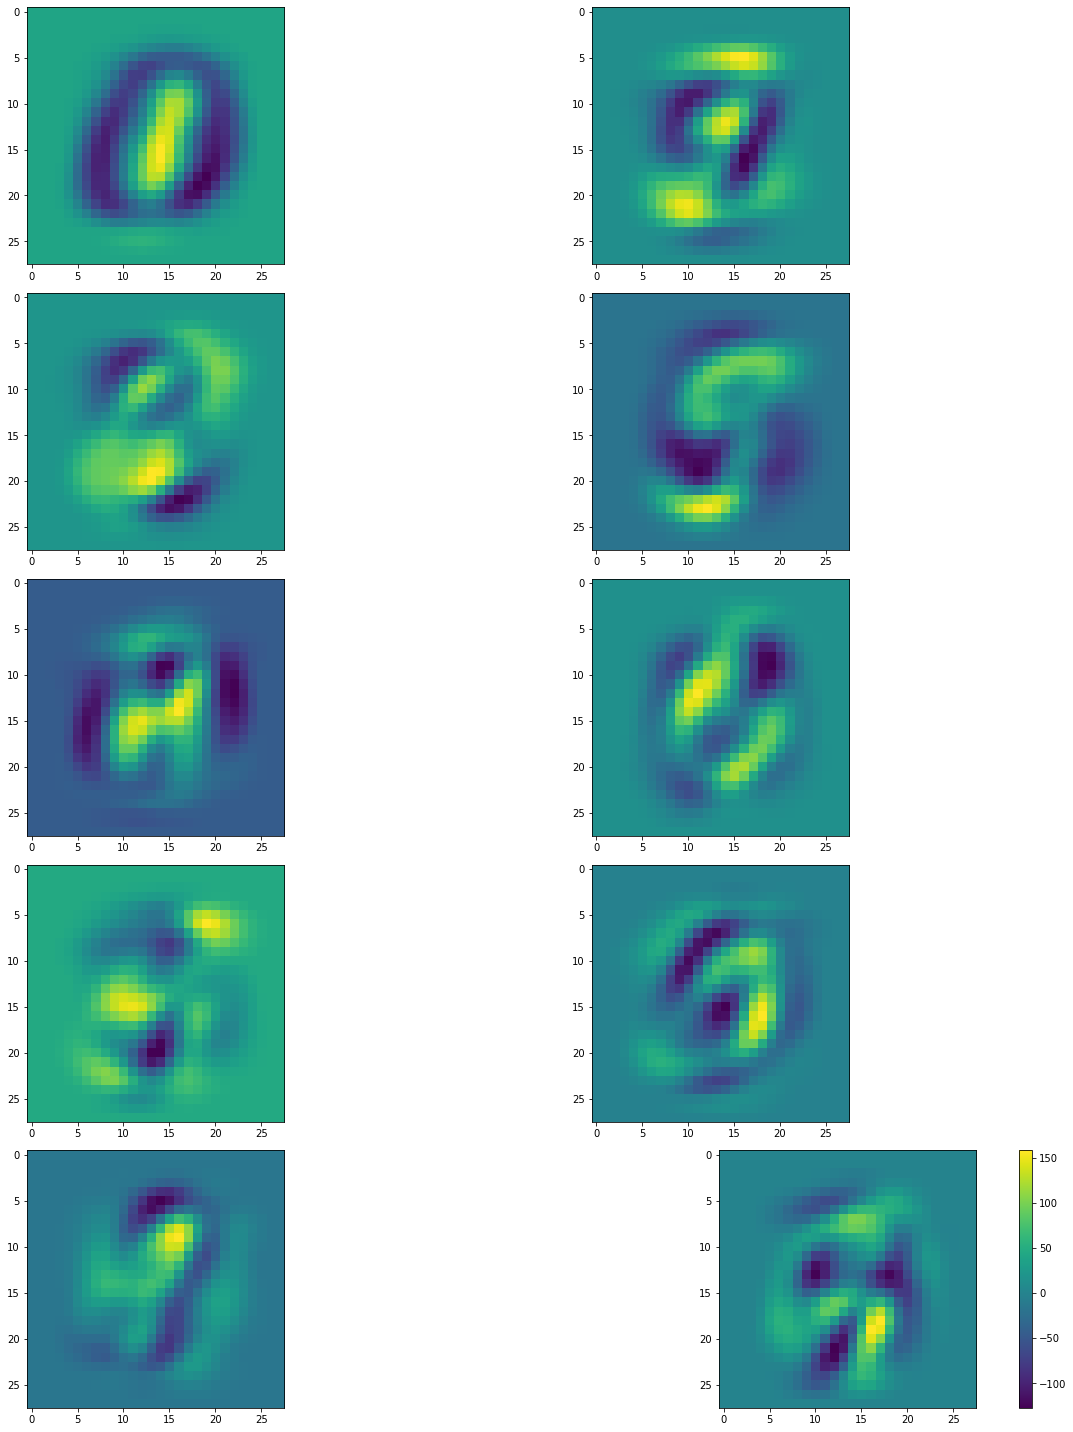

In [9]:
%matplotlib inline
plt.subplots(2, 5, figsize=(20, 20))
for i in range(0, 10):
    plt.subplot(5, 2, i+1)
    temp = np.reshape((1000*U[:, i]).astype(int), (28, 28))
    temp[-1, -1] = 0
    plt.imshow(temp)
plt.colorbar()
plt.tight_layout()
plt.show()

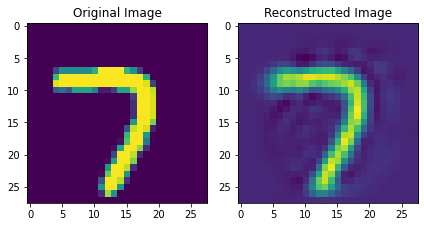

In [10]:
%matplotlib inline
idx = np.random.randint(0, train_images.shape[1])
rank = rank # 20 is enough when ignoring negatives (setting them to 0), but the rank is more like 300
re_S = np.zeros(len(S))
re_S[:rank] = S[:rank]
re_images = U @ np.diag(re_S) @ Vh
re_im = np.reshape((1000*(re_images[:, idx] + avg_im[:, 0])).astype(int), (28, 28))
og_im = np.reshape((1000*train_images[:, idx]).astype(int), (28, 28))
plt.subplots(1, 2)
plt.subplot(121)
plt.title("Original Image")
plt.imshow(og_im)
plt.subplot(122)
plt.title("Reconstructed Image")
plt.imshow(re_im)
plt.tight_layout()

20 modes is enough to reconstruct the images. 10 dimensions was not enough, and nor was 15

# Coordinates of digits in the first 3 principle components

(3, 1000)


<IPython.core.display.Javascript object>


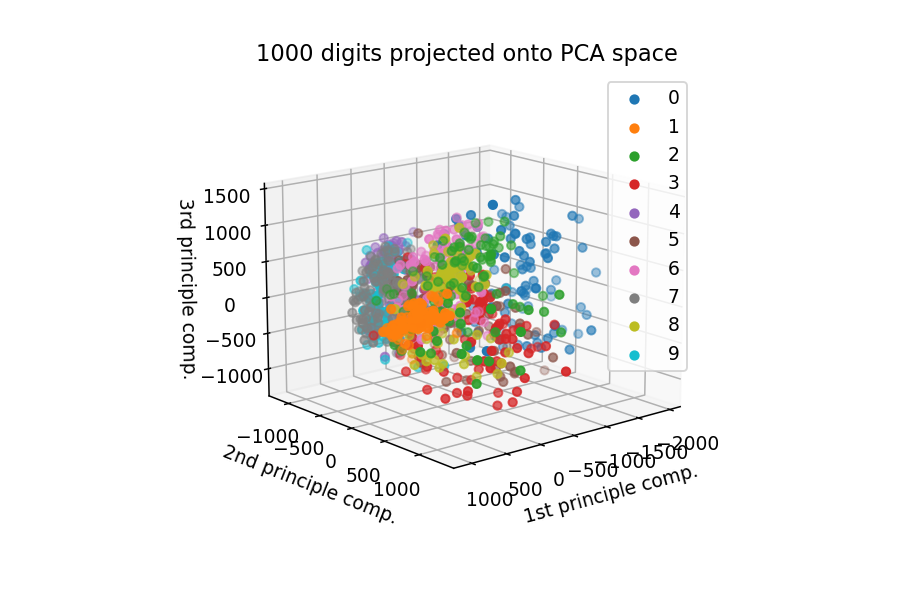

In [11]:
# by the nature of the SVD, the first 3 rows of \Sigma V^T tell you how the images are projected onto the princple component
sample_size = 1000
proj_images = np.diag(S[:3]) @ Vh[:3, :sample_size]
print(proj_images.shape)

%matplotlib notebook
fig = plt.figure(dpi=120)
ax = fig.gca(projection='3d')
plt.title("1000 digits projected onto PCA space")
for digit in range(10):
    dig_ims = proj_images[:, np.nonzero(train_labels[:sample_size]==digit)]
    ax.scatter(dig_ims[0, :], dig_ims[1, :], dig_ims[2, :], label=str(digit))
ax.view_init(elev=15, azim=50)
plt.xlabel("1st principle comp.")
plt.ylabel("2nd principle comp.")
ax.set_zlabel("3rd principle comp.")
plt.legend()
plt.show()

In [12]:
cumul_var[3] / cumul_var[-1]

0.2835909666772994

# Linear Discriminant Analysis

In [61]:
proj_size = 10
print(cumul_var[proj_size] / cumul_var[-1])
proj_train_ims = np.diag(S[:proj_size]) @ Vh[:proj_size, :]
avg_test = np.mean(test_images, axis=1, keepdims=True)
proj_test_ims = np.transpose(U[:, :proj_size]) @ (test_images - avg_test)  # project test images onto the U modes found in training step

clf = LDA()

0.5092416997000104


In [53]:
min_err = 1
max_err = 0
argmin_digs = None
argmax_digs = None
for dig1 in range(10):
    for dig2 in range(dig1):
        print(dig1, dig2)
        train_pair_ims = np.transpose(proj_train_ims[:, np.nonzero(np.logical_or(train_labels==dig1, train_labels==dig2))[0]])
        train_pair_labels = train_labels[np.nonzero(np.logical_or(train_labels==dig1, train_labels==dig2))[0]]
        clf.fit(train_pair_ims, train_pair_labels)

        test_pair_ims = np.transpose(proj_test_ims[:, np.nonzero(np.logical_or(test_labels==dig1, test_labels==dig2))[0]])
        test_pair_labels = test_labels[np.nonzero(np.logical_or(test_labels==dig1, test_labels==dig2))[0]]

        train_fit = clf.predict(train_pair_ims)
        train_err = np.sum((train_fit != train_pair_labels).astype(int)) / len(train_fit)
        print("Training Set Error:", train_err)
        predic = clf.predict(test_pair_ims)
        error = np.sum((predic != test_pair_labels).astype(int)) / len(predic)
        print("Test Set Error:", error, "\n")
        if min_err > error:
            min_err = error
            argmin_digs = (dig1, dig2)
            
        if max_err < error:
            max_err = error
            argmax_digs = (dig1, dig2)
            
print("Easiest to distinguish digits:", *argmin_digs, " with error", min_err)
print("Hardest to distinguish digits:", *argmax_digs, " with error", max_err)
# 1 0
# Training Set Error: 0.004658507698381366
# Test Set Error: 0.0018912529550827422 

# 2 0
# Training Set Error: 0.03391970372864237
# Test Set Error: 0.0268389662027833 

# 2 1
# Training Set Error: 0.02874015748031496
# Test Set Error: 0.03461005999077065 

# 3 0
# Training Set Error: 0.03625352580056413
# Test Set Error: 0.021105527638190954 

# 3 1
# Training Set Error: 0.025168958284782102
# Test Set Error: 0.02191142191142191 

# 3 2
# Training Set Error: 0.051038133840681614
# Test Set Error: 0.042605288932419196 

# 4 0
# Training Set Error: 0.009944751381215469
# Test Set Error: 0.011722731906218144 

# 4 1
# Training Set Error: 0.010251112523839796
# Test Set Error: 0.007085498346717053 

# 4 2
# Training Set Error: 0.036016949152542374
# Test Set Error: 0.02830188679245283 

# 4 3
# Training Set Error: 0.021715526601520086
# Test Set Error: 0.015060240963855422 

# 5 0
# Training Set Error: 0.06170662905500705
# Test Set Error: 0.057692307692307696 

# 5 1
# Training Set Error: 0.019649757461152675
# Test Set Error: 0.010853478046373951 

# 5 2
# Training Set Error: 0.0466649090429739
# Test Set Error: 0.04573804573804574 

# 5 3
# Training Set Error: 0.1109764542936288
# Test Set Error: 0.09989484752891693 

# 5 4
# Training Set Error: 0.03436029477048744
# Test Set Error: 0.029882604055496264 

# 6 0
# Training Set Error: 0.029389409678236635
# Test Set Error: 0.037667698658410735 

# 6 1
# Training Set Error: 0.02022116903633491
# Test Set Error: 0.018633540372670808 

# 6 2
# Training Set Error: 0.07805658470865612
# Test Set Error: 0.07035175879396985 

# 6 3
# Training Set Error: 0.018258776661963648
# Test Set Error: 0.01676829268292683 

# 6 4
# Training Set Error: 0.019302721088435375
# Test Set Error: 0.01907216494845361 

# 6 5
# Training Set Error: 0.044977511244377814
# Test Set Error: 0.051351351351351354 

# 7 0
# Training Set Error: 0.013619954053167049
# Test Set Error: 0.01195219123505976 

# 7 1
# Training Set Error: 0.019835473206734833
# Test Set Error: 0.02912621359223301 

# 7 2
# Training Set Error: 0.03313425509285773
# Test Set Error: 0.0383495145631068 

# 7 3
# Training Set Error: 0.029444982252339463
# Test Set Error: 0.03434739941118744 

# 7 4
# Training Set Error: 0.036672999091434705
# Test Set Error: 0.03482587064676617 

# 7 5
# Training Set Error: 0.029779223001882595
# Test Set Error: 0.0265625 

# 7 6
# Training Set Error: 0.006320282360666503
# Test Set Error: 0.013595166163141994 

# 8 0
# Training Set Error: 0.023016816714795312
# Test Set Error: 0.016888433981576252 

# 8 1
# Training Set Error: 0.051377749543397126
# Test Set Error: 0.03698435277382646 

# 8 2
# Training Set Error: 0.05385722753831823
# Test Set Error: 0.050348953140578266 

# 8 3
# Training Set Error: 0.09380737773326657
# Test Set Error: 0.08669354838709678 

# 8 4
# Training Set Error: 0.02274865304028051
# Test Set Error: 0.025051124744376277 

# 8 5
# Training Set Error: 0.08339247693399574
# Test Set Error: 0.08092175777063237 

# 8 6
# Training Set Error: 0.0225167813747982
# Test Set Error: 0.024327122153209108 

# 8 7
# Training Set Error: 0.030868273357543743
# Test Set Error: 0.038461538461538464 

# 9 0
# Training Set Error: 0.019036388140161724
# Test Set Error: 0.019105077928607342 

# 9 1
# Training Set Error: 0.016625955401465605
# Test Set Error: 0.012126865671641791 

# 9 2
# Training Set Error: 0.03334173175443017
# Test Set Error: 0.030867221950024497 

# 9 3
# Training Set Error: 0.04461920529801325
# Test Set Error: 0.037642397226349676 

# 9 4
# Training Set Error: 0.15511831057586295
# Test Set Error: 0.1592164741336012 

# 9 5
# Training Set Error: 0.04722955145118733
# Test Set Error: 0.04418726985796949 

# 9 6
# Training Set Error: 0.010027808207634617
# Test Set Error: 0.012709710218607015 

# 9 7
# Training Set Error: 0.09644670050761421
# Test Set Error: 0.09081983308787432 

# 9 8
# Training Set Error: 0.05406779661016949
# Test Set Error: 0.05849722642460918 

# Easiest to distinguish digits: 1 0  with error 0.0018912529550827422
# Hardest to distinguish digits: 9 4  with error 0.1592164741336012

1 0
Training Set Error: 0.004658507698381366
Test Set Error: 0.0018912529550827422 

2 0
Training Set Error: 0.03391970372864237
Test Set Error: 0.0268389662027833 

2 1
Training Set Error: 0.02874015748031496
Test Set Error: 0.03461005999077065 

3 0
Training Set Error: 0.03625352580056413
Test Set Error: 0.021105527638190954 

3 1
Training Set Error: 0.025168958284782102
Test Set Error: 0.02191142191142191 

3 2
Training Set Error: 0.051038133840681614
Test Set Error: 0.042605288932419196 

4 0
Training Set Error: 0.009944751381215469
Test Set Error: 0.011722731906218144 

4 1
Training Set Error: 0.010251112523839796
Test Set Error: 0.007085498346717053 

4 2
Training Set Error: 0.036016949152542374
Test Set Error: 0.02830188679245283 

4 3
Training Set Error: 0.021715526601520086
Test Set Error: 0.015060240963855422 

5 0
Training Set Error: 0.06170662905500705
Test Set Error: 0.057692307692307696 

5 1
Training Set Error: 0.019649757461152675
Test Set Error: 0.010853478046373951 



### 3 digit classification

In [54]:
dig1 = 2
dig2 = 7
dig3 = 8

train_trip_ims = np.transpose(proj_train_ims[:, np.nonzero(np.logical_or.reduce((train_labels==dig1, train_labels==dig2, train_labels==dig3)))[0]])
train_trip_labels = train_labels[np.nonzero(np.logical_or.reduce((train_labels==dig1, train_labels==dig2, train_labels==dig3)))[0]]
clf.fit(train_trip_ims, train_trip_labels)

test_trip_ims = np.transpose(proj_test_ims[:, np.nonzero(np.logical_or.reduce((test_labels==dig1, test_labels==dig2, test_labels==dig3)))[0]])
test_trip_labels = test_labels[np.nonzero(np.logical_or.reduce((test_labels==dig1, test_labels==dig2, test_labels==dig3)))[0]]

train_fit = clf.predict(train_trip_ims)
train_err = np.sum((train_fit != train_trip_labels).astype(int)) / len(train_fit)
print("Training Set Error:", train_err)
predic = clf.predict(test_trip_ims)
error = np.sum((predic != test_trip_labels).astype(int)) / len(predic)
print("Test Set Error:", error)

Training Set Error: 0.0698240566559699
Test Set Error: 0.07251153592617007


## LDA on all 10 digits

In [55]:
clf.fit(np.transpose(proj_train_ims), train_labels)

LinearDiscriminantAnalysis()

In [56]:
train_fit = clf.predict(np.transpose(proj_train_ims))
train_err = np.sum((train_fit != train_labels).astype(int)) / len(train_fit)
print("Training Set Error:", train_err)
predic = clf.predict(np.transpose(proj_test_ims))
error = np.sum((predic != test_labels).astype(int)) / len(predic)
print("Test Set Error:", error)

Training Set Error: 0.23266666666666666
Test Set Error: 0.2269


## Support Vector Machine on all 10 digits

In [63]:
svmclf = svm.SVC(decision_function_shape='ovr')  # one versus one
svmclf.fit(np.transpose(proj_train_ims), train_labels)

SVC()

In [64]:
train_fit = svmclf.predict(np.transpose(proj_train_ims))
train_err = np.sum((train_fit != train_labels).astype(int)) / len(train_fit)
print("Training Set Error:", train_err)
predic = svmclf.predict(np.transpose(proj_test_ims))
error = np.sum((predic != test_labels).astype(int)) / len(predic)
print("Test Set Error:", error)

Training Set Error: 0.05658333333333333
Test Set Error: 0.064


## Decision Tree on all 10 digits

In [19]:
treeclf = tree.DecisionTreeClassifier(min_samples_leaf=5)  # regularize
treeclf.fit(np.transpose(proj_train_ims), train_labels)

DecisionTreeClassifier(min_samples_leaf=5)

In [20]:
train_fit = treeclf.predict(np.transpose(proj_train_ims))
train_err = np.sum((train_fit != train_labels).astype(int)) / len(train_fit)
print("Training Set Error:", train_err)
predic = treeclf.predict(np.transpose(proj_test_ims))
error = np.sum((predic != test_labels).astype(int)) / len(predic)
print("Test Set Error:", error)

Training Set Error: 0.07895
Test Set Error: 0.1665


## Comparison on the easiest and hardest pairs of digits
### Easiest

In [21]:
dig1 = argmin_digs[0]
dig2 = argmin_digs[1]
train_pair_ims = np.transpose(proj_train_ims[:, np.nonzero(np.logical_or(train_labels==dig1, train_labels==dig2))[0]])
train_pair_labels = train_labels[np.nonzero(np.logical_or(train_labels==dig1, train_labels==dig2))[0]]
test_pair_ims = np.transpose(proj_test_ims[:, np.nonzero(np.logical_or(test_labels==dig1, test_labels==dig2))[0]])
test_pair_labels = test_labels[np.nonzero(np.logical_or(test_labels==dig1, test_labels==dig2))[0]]

### SVM Classification

In [22]:
svmclf = svm.SVC()
svmclf.fit(train_pair_ims, train_pair_labels)

SVC()

In [23]:
train_fit = svmclf.predict(train_pair_ims)
train_err = np.sum((train_fit != train_pair_labels).astype(int)) / len(train_fit)
print("Training Set Error:", train_err)
predic = svmclf.predict(test_pair_ims)
error = np.sum((predic != test_pair_labels).astype(int)) / len(predic)
print("Test Set Error:", error, "\n")

Training Set Error: 0.0012633241215949467
Test Set Error: 0.0014184397163120568 



### Decision Tree Classification

In [24]:
treeclf = tree.DecisionTreeClassifier(min_samples_leaf=5)  # regularize
treeclf.fit(train_pair_ims, train_pair_labels)

DecisionTreeClassifier(min_samples_leaf=5)

In [25]:
train_fit = treeclf.predict(train_pair_ims)
train_err = np.sum((train_fit != train_pair_labels).astype(int)) / len(train_fit)
print("Training Set Error:", train_err)
predic = treeclf.predict(test_pair_ims)
error = np.sum((predic != test_pair_labels).astype(int)) / len(predic)
print("Test Set Error:", error, "\n")

Training Set Error: 0.0018949861823924202
Test Set Error: 0.0037825059101654845 



### Hardest

In [26]:
dig1 = argmax_digs[0]
dig2 = argmax_digs[1]
train_pair_ims = np.transpose(proj_train_ims[:, np.nonzero(np.logical_or(train_labels==dig1, train_labels==dig2))[0]])
train_pair_labels = train_labels[np.nonzero(np.logical_or(train_labels==dig1, train_labels==dig2))[0]]
test_pair_ims = np.transpose(proj_test_ims[:, np.nonzero(np.logical_or(test_labels==dig1, test_labels==dig2))[0]])
test_pair_labels = test_labels[np.nonzero(np.logical_or(test_labels==dig1, test_labels==dig2))[0]]

### SVM Classification

In [27]:
svmclf = svm.SVC()
svmclf.fit(train_pair_ims, train_pair_labels)

SVC()

In [28]:
train_fit = svmclf.predict(train_pair_ims)
train_err = np.sum((train_fit != train_pair_labels).astype(int)) / len(train_fit)
print("Training Set Error:", train_err)
predic = svmclf.predict(test_pair_ims)
error = np.sum((predic != test_pair_labels).astype(int)) / len(predic)
print("Test Set Error:", error, "\n")

Training Set Error: 0.048257145280298536
Test Set Error: 0.053741838272225013 



### Decision Tree Classification

In [29]:
treeclf = tree.DecisionTreeClassifier(min_samples_leaf=5)  # regularize
treeclf.fit(train_pair_ims, train_pair_labels)

DecisionTreeClassifier(min_samples_leaf=5)

In [30]:
train_fit = treeclf.predict(train_pair_ims)
train_err = np.sum((train_fit != train_pair_labels).astype(int)) / len(train_fit)
print("Training Set Error:", train_err)
predic = treeclf.predict(test_pair_ims)
error = np.sum((predic != test_pair_labels).astype(int)) / len(predic)
print("Test Set Error:", error, "\n")

Training Set Error: 0.050292596047833094
Test Set Error: 0.13510798593671522 

